# Experiment tracking using tensorboard

`torch.utils.tensorboard.SummaryWriter`

## 1. Import Libraries

In [18]:
import random
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from datetime import datetime

import torch
import torch.nn as nn

import torchvision

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary
from torcheval.metrics.functional import multiclass_accuracy

import engine
import utils

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

RAMDOM_SEED = 42

%load_ext autoreload
%autoreload 2

torch: 2.2.0
torchvision: 0.17.0
device: cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Get Dataset

### 2.1 Downloading dataset from url

In [19]:
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_dir = "pizza_steak_sushi"
image_dir = utils.download_dataset_from_url(url, data_dir)

data/pizza_steak_sushi directory exists.


### 2.2 Creating directories

In [20]:
train_dir = image_dir / "train"
test_dir = image_dir / "test"
image_path_list = list(image_dir.glob("*/*/*.jpg"))

print(f"image directory : {image_dir}")
print(f"train directory : {train_dir}")
print(f"test  directory : {test_dir}")
print(f"number of all images : {len(image_path_list)}")

image directory : data/pizza_steak_sushi
train directory : data/pizza_steak_sushi/train
test  directory : data/pizza_steak_sushi/test
number of all images : 300


### 2.3 Visualizing the raw images

In [ ]:
random.seed(RAMDOM_SEED)

rows, cols = 4, 4
random_image_paths = random.sample(image_path_list, k=rows*cols)

fig = plt.figure(figsize=(9, 9))
plt.suptitle("Raw Images")
plt.axis(False)
for i, image_path in enumerate(random_image_paths, start=1):
    label = image_path.parent.stem
    ax = fig.add_subplot(rows, cols, i)
    with Image.open(image_path) as img:
        plt.imshow(img)
    ax.set_title(label)
    ax.axis(False)

## 3. Model_0: Using pre-trained model
`EfficientNet_B0`

### 3.1 Downloading model

In [22]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
preprocess = weights.transforms(antialias=True)
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.2 Creating `train_data` and `test_data`

In [23]:
train_data = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=preprocess,
)

test_data = torchvision.datasets.ImageFolder(
    root=test_dir,
    transform=preprocess,
)

In [24]:
print(f"train data: {len(train_data)}")
print(f"test data : {len(test_data)}")

class_names = train_data.classes
NUM_CLASSES = len(class_names)
print(f"number of classes: {NUM_CLASSES}")
print(f"\nclass names:\n{class_names}")

class_to_idx = train_data.class_to_idx
print(f"\nclass to index:\n{class_to_idx}")

targets = train_data.targets
print(f"\nlength of targets:\n{len(targets)}")

image, label = train_data[0]
INPUT_IMAGE_SIZE = image.shape
print(f"\nimage shape:\n{INPUT_IMAGE_SIZE} -> [color_channels, height, width]")
print(f"\nimage index label:\n{label}")
print(f"\nimage label:\n{class_names[label]}")

train data: 225
test data : 75
number of classes: 3

class names:
['pizza', 'steak', 'sushi']

class to index:
{'pizza': 0, 'steak': 1, 'sushi': 2}

length of targets:
225

image shape:
torch.Size([3, 224, 224]) -> [color_channels, height, width]

image index label:
0

image label:
pizza


### 3.3 Using `DataLoader()` to turn `train_data` and `test_data` into batches.

In [25]:
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"train dataloader: {train_dataloader}")
print(f"test Dataloader : {test_dataloader}")
print(f"length of train dataloader: {len(train_dataloader)} batches of \
{BATCH_SIZE} ({len(train_dataloader)*BATCH_SIZE})")
print(f"length of test dataloader : {len(test_dataloader)} batches of \
{BATCH_SIZE} ({len(test_dataloader)*BATCH_SIZE})")

Creating DataLoader's with batch size 8 and 4 workers.
train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7ffb0be4c3a0>
test Dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7ffb0be4c190>
length of train dataloader: 29 batches of 8 (232)
length of test dataloader : 10 batches of 8 (80)


### 3.4 Creating feature extraction model from `EfficientNet_B0`

In [26]:
torchvision.models.efficientnet_b0(weights=weights).classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [27]:
def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    utils.set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=NUM_CLASSES),
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [28]:
model_0 = create_effnetb0()
summary(
    model_0,
    input_size=(1, 3, 224, 224), # (batch_size, color_channel, height, weight)
    col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"],
    row_settings=["var_names"]
)

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 3]                    --                        --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     [3, 3]                    False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      

### Create a summary writer function

In [29]:
def create_writer(
    experiment_name: str,
    model_name: str,
    extra: str | None = None,
) -> SummaryWriter:
    """Creates a torch.utils.tensorboard.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.SummaryWriter(): Instance of a writer saving to log_dir.
    """

    timestamp = datetime.now().strftime("%Y-%m-%d")
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

### 3.5 Train the model with different epochs


In [31]:
utils.set_seeds(seed=42)
experiment_number = 0
num_epochs = [5, 10]
experiment_name = "experiment_0"
model = model_0

for epochs in num_epochs:
    experiment_number += 1
    print(f"[INFO] Experiment number: {experiment_number}")
    print(f"[INFO] Model: {model.name}")
    print(f"[INFO] Number of epochs: {epochs}")

    model = create_effnetb0()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    activation_fn = lambda x: torch.argmax(x, dim=1)
    writer = create_writer(experiment_name, model.name, f"{epochs}_epochs")

    results = engine.train(
        epochs=epochs,
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        activation_fn=activation_fn,
        accuracy_fn=multiclass_accuracy,
        device=device,
        writer=writer,
    )

    save_filepath = f"{model.name}_{epochs}_epochs.pth"
    utils.save_model(
        model=model,
        target_dir="models",
        model_name=save_filepath,
        results=results,
    )
    print("-" * 50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-12/experiment_0/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   1 | train_loss: 0.9996 | train_acc: 0.5086 | test_loss: 0.7826 | test_acc: 0.7833
Epoch:   2 | train_loss: 0.7099 | train_acc: 0.8103 | test_loss: 0.6202 | test_acc: 0.8625
Epoch:   3 | train_loss: 0.5761 | train_acc: 0.8103 | test_loss: 0.5258 | test_acc: 0.8875
Epoch:   4 | train_loss: 0.5249 | train_acc: 0.8190 | test_loss: 0.4595 | test_acc: 0.8750
Epoch:   5 | train_loss: 0.4406 | train_acc: 0.8922 | test_loss: 0.4346 | test_acc: 0.8750
[INFO] Saving model to: models/effnetb0_5_epochs.pth
[INFO] Saving training results to: models/effnetb0_5_epochs.json
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb0
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-12/experiment_0/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   1 | train_loss: 0.9996 | train_acc: 0.5086 | test_loss: 0.7826 | test_acc: 0.7833
Epoch:   2 | train_loss: 0.7099 | train_acc: 0.8103 | test_loss: 0.6202 | test_acc: 0.8625
Epoch:   3 | train_loss: 0.5761 | train_acc: 0.8103 | test_loss: 0.5258 | test_acc: 0.8875
Epoch:   4 | train_loss: 0.5249 | train_acc: 0.8190 | test_loss: 0.4595 | test_acc: 0.8750
Epoch:   5 | train_loss: 0.4406 | train_acc: 0.8922 | test_loss: 0.4346 | test_acc: 0.8750
Epoch:   6 | train_loss: 0.5112 | train_acc: 0.7888 | test_loss: 0.3882 | test_acc: 0.9000
Epoch:   7 | train_loss: 0.3890 | train_acc: 0.8707 | test_loss: 0.3606 | test_acc: 0.9000
Epoch:   8 | train_loss: 0.3669 | train_acc: 0.8664 | test_loss: 0.3641 | test_acc: 0.8875
Epoch:   9 | train_loss: 0.3930 | train_acc: 0.8879 | test_loss: 0.3474 | test_acc: 0.8750
Epoch:  10 | train_loss: 0.3669 | train_acc: 0.8836 | test_loss: 0.3426 | test_acc: 0.9000
[INFO] Saving model to: models/effnetb0_10_epochs.pth
[INFO] Saving training results to: m

### 3.6 Plot loss and accuracy curves

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

### 4.4 Make predictions and get model_0 results


In [35]:
model_0_result = engine.test_step(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    activation_fn=activation_fn,
    accuracy_fn=multiclass_accuracy,
    device=device,
)
model_name = model_0.__class__.__name__
model_loss = model_0_result[0]
model_accuracy = model_0_result[1]
print(f"Results for {model_name}:")
print(f"loss = {model_loss:.3f}, accuracy = {model_accuracy:.3f}")

Results for EfficientNet:
loss = 1.093, accuracy = 0.350


In [36]:
model_1_result = engine.test_step(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    activation_fn=activation_fn,
    accuracy_fn=multiclass_accuracy,
    device=device,
)
model_name = model.__class__.__name__
model_loss = model_1_result[0]
model_accuracy = model_1_result[1]
print(f"Results for {model_name}:")
print(f"loss = {model_loss:.3f}, accuracy = {model_accuracy:.3f}")

Results for EfficientNet:
loss = 0.343, accuracy = 0.900


### 4.6 Make and evaluate random predictions


#### 4.6.1 Create samples from data


In [60]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor(),
    ]
)

test_images = torchvision.datasets.ImageFolder(
    root=test_dir,
    transform=transform,
)

In [61]:
samples, lables = utils.create_samples(
    data=test_images, num_samples=9, random_seed=RAMDOM_SEED
)
lables

[0, 0, 1, 1, 1, 0, 0, 0, 2]

#### 4.6.2 Make predictions and plot with model_0 (before training)


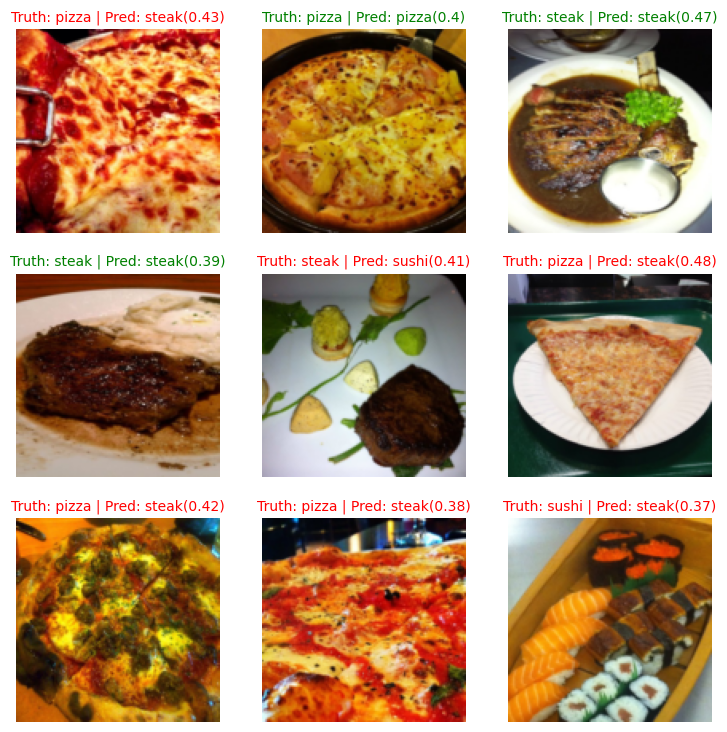

In [63]:
predictions_0 = utils.make_predictions(model=model_0, samples=samples, device=device)

utils.plot_predictions(
    samples=samples,
    lables=lables,
    predictions=predictions_0,
    class_names=class_names,
)

#### 4.6.3 Make predictions and plot with model (after training)


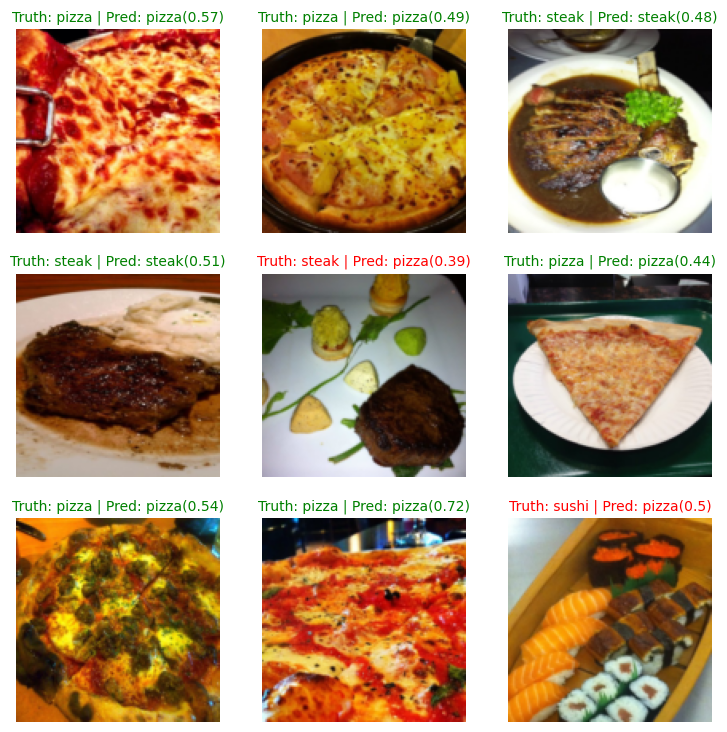

In [64]:
predictions_1 = utils.make_predictions(model=model, samples=samples, device=device)

utils.plot_predictions(
    samples=samples,
    lables=lables,
    predictions=predictions_1,
    class_names=class_names,
)